# Check uncertainty estimates


[can't start cudnn algorithm](https://stackoverflow.com/questions/53698035/failed-to-get-convolution-algorithm-this-is-probably-because-cudnn-failed-to-in)

In [1]:
import os, sys, importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split


BASE_PATH = os.path.join(os.getcwd(), "..", "..")
MODULE_PATH = os.path.join(BASE_PATH, "modules")
DATASET_PATH = os.path.join(BASE_PATH, "datasets")

sys.path.append(MODULE_PATH)

from bayesian import McDropout, MomentPropagation
import data.mnist as mnist_loader
from models.default import default_model
from models.tf_growth import setup_growth


%load_ext autoreload 

## Prepare Data

In [2]:
inputs, targets = mnist_loader.load(os.path.join(DATASET_PATH, "mnist"))

In [3]:
print("Inputs-Shape: {}".format(inputs.shape))
print("Targets-Shape: {}".format(targets.shape))

Inputs-Shape: (70000, 28, 28)
Targets-Shape: (70000,)


In [4]:
selector = (targets==0) | (targets==1)
new_inputs = inputs[selector]
new_targets = targets[selector]

In [5]:
x_train, x_test, y_train, y_test = train_test_split(np.expand_dims(new_inputs, axis=-1), new_targets)

## Train and build models

In [6]:
setup_growth()

1 Physical GPU's,  1 Logical GPU's


In [7]:
model = default_model()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])

In [8]:
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
347/347 [==============================] - 6s 17ms/step - loss: 0.0830 - binary_accuracy: 0.9933
Epoch 2/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0108 - binary_accuracy: 0.9982
Epoch 3/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0068 - binary_accuracy: 0.9984
Epoch 4/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0055 - binary_accuracy: 0.9988
Epoch 5/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0135 - binary_accuracy: 0.9977
Epoch 6/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0146 - binary_accuracy: 0.9979
Epoch 7/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0132 - binary_accuracy: 0.9986
Epoch 8/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0266 - binary_accuracy: 0.9975
Epoch 9/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0056 - binary_accuracy: 0.9989
Epoch 10/100
347/347 [=====

347/347 [==============================] - 1s 3ms/step - loss: 0.0026 - binary_accuracy: 0.9991
Epoch 76/100
347/347 [==============================] - 1s 3ms/step - loss: 2.6784e-04 - binary_accuracy: 0.9999
Epoch 77/100
347/347 [==============================] - 1s 4ms/step - loss: 1.1196e-04 - binary_accuracy: 0.9999
Epoch 78/100
347/347 [==============================] - 1s 4ms/step - loss: 1.1814e-05 - binary_accuracy: 1.0000
Epoch 79/100
347/347 [==============================] - 1s 4ms/step - loss: 9.7710e-04 - binary_accuracy: 0.9998
Epoch 80/100
347/347 [==============================] - 1s 4ms/step - loss: 1.7627e-04 - binary_accuracy: 0.9999
Epoch 81/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0099 - binary_accuracy: 0.9978
Epoch 82/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0067 - binary_accuracy: 0.9979
Epoch 83/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0063 - binary_accuracy: 0.9983
Epoch 84/100

## Evaluate performance

In [9]:
model.evaluate(x_test, y_test)

116/116 [==============================] - 2s 19ms/step - loss: 0.0041 - binary_accuracy: 0.9962


[0.00406778184697032, 0.9962111115455627]

Predicted label: [[0.]]


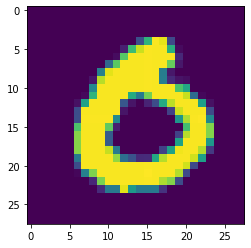

In [10]:
random_indx = np.random.choice(range(len(x_test)))

test_img = x_test[random_indx]
plt.imshow(test_img.reshape((28, 28)))

prediction = model(np.expand_dims(test_img, axis=0))

print("Predicted label: {}".format(prediction))

## Metric Comparison

In [11]:
%autoreload 2
dp_model = McDropout(model)
mp_model = MomentPropagation(model)

In [38]:
test_inputs = x_test[:10]
y_test[:10]

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1], dtype=uint8)

In [27]:
values = dp_model.predict(test_inputs)

In [79]:
# mc dropout max_entropy
mc_max_entropy = dp_model.get_query_fn("max_entropy")(x_test[10:50], runs=5)
mc_max_entropy

[[-9.13793852e-01 -5.09160344e-01]
 [-5.09160344e-01 -9.13793852e-01]
 [-2.21894332e-01 -1.60445037e+00]
 [-5.09160344e-01 -9.13793852e-01]
 [ 9.99500333e-04 -6.90775528e+00]
 [-5.09160344e-01 -9.13793852e-01]
 [-3.73132730e-01 -1.16019146e+00]
 [-5.09160344e-01 -9.13793852e-01]
 [-9.13793852e-01 -5.09160344e-01]
 [-5.09160344e-01 -9.13793852e-01]
 [-2.21894332e-01 -1.60445037e+00]
 [-5.09160344e-01 -9.13793852e-01]
 [ 9.99500333e-04 -6.90775528e+00]
 [-5.09160344e-01 -9.13793852e-01]
 [-5.09160344e-01 -9.13793852e-01]
 [-5.09160344e-01 -9.13793852e-01]
 [-9.13793852e-01 -5.09160344e-01]
 [-5.09160344e-01 -9.13793852e-01]
 [-2.21894332e-01 -1.60445037e+00]
 [-5.09160344e-01 -9.13793852e-01]
 [ 9.99500333e-04 -6.90775528e+00]
 [-7.16264678e-01 -6.66649042e-01]
 [-3.73132730e-01 -1.16019146e+00]
 [-5.09160344e-01 -9.13793852e-01]
 [-9.13793852e-01 -5.09160344e-01]
 [-5.09160344e-01 -9.13793852e-01]
 [-2.21894332e-01 -1.60445037e+00]
 [-5.09160344e-01 -9.13793852e-01]
 [ 9.99500333e-04 -6

array([ 0.67101375,  0.67101375,  0.49840554,  0.67101375, -0.0009995 ,
        0.67101375,  0.61903047,  0.67101375,  0.67101375,  0.67101375,
        0.49840554,  0.67101375, -0.0009995 ,  0.67101375,  0.67101375,
        0.67101375,  0.67101375,  0.67101375,  0.49840554,  0.67101375,
       -0.0009995 ,  0.69084033,  0.61903047,  0.67101375,  0.67101375,
        0.67101375,  0.49840554,  0.67101375, -0.0009995 ,  0.69084033,
        0.67101375,  0.67101375,  0.67101375,  0.67101375,  0.49840554,
        0.67101375, -0.0009995 ,  0.69084033,  0.67101375,  0.67101375])

In [81]:
# moment propagation max entropy
%autoreload 2
mp_max_entropy = mp_model.get_query_fn("max_entropy")(test_inputs)
mp_max_entropy

h4
[[1.001e+00 1.000e-03]
 [1.001e+00 1.000e-03]
 [1.001e+00 1.000e-03]
 [1.000e-03 1.001e+00]
 [1.001e+00 1.000e-03]
 [1.001e+00 1.000e-03]
 [1.001e+00 1.000e-03]
 [1.001e+00 1.000e-03]
 [1.000e-03 1.001e+00]
 [1.001e+00 1.000e-03]]


array([-7.908756, -7.908756, -7.908756, -7.908756, -7.908756, -7.908756,
       -7.908756, -7.908756, -7.908756, -7.908756], dtype=float32)